# Importing the dependencies

In [25]:
# Importing the dependencies
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras import Sequential,layers
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
import os
print("Everything imported successfully !")

Everything imported successfully !


In [2]:
# To enable numpy operations on the tensor
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [3]:
# Variable to keep track of number of corrupt images and images deleted
num_skipped = 0

for folder_name in ("Healthy", "Powdery","Rust"):

    # Path of all the above mentioned directories
    folder_path = os.path.join("/kaggle/input/plant-disease-recognition-dataset/Train/Train",folder_name)

    # Iterating through each and every file(image) in the respective directory
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname) # Constructing path to each of the file
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10) # Checking if JFIF string is present
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

# Let's see how many corrupt images are there
print("Deleted %d images" % num_skipped)

Deleted 0 images


# Creating input pipeline for data loading

In [29]:
# Let's create tf.data.Dataset for model training
with tf.device('/cpu:0'):

    # Training data
    train_ds = tf.keras.utils.image_dataset_from_directory(
        directory="/kaggle/input/plant-disease-recognition-dataset/Train/Train",
        batch_size=16,
        image_size=(256, 256),
        shuffle=True,
        validation_split=None,
        seed=123
    )

    # Validation data
    val_ds =  tf.keras.utils.image_dataset_from_directory(
        directory="/kaggle/input/plant-disease-recognition-dataset/Validation/Validation",
        batch_size=16,
        image_size=(256, 256),
        shuffle=True,
        validation_split=None,
        seed=123
    )
    
    # Test data
    test_ds =  tf.keras.utils.image_dataset_from_directory(
        directory="/kaggle/input/plant-disease-recognition-dataset/Test/Test",
        batch_size=16,
        image_size=(256, 256),
        shuffle=True,
        validation_split=None,
        seed=123
    )
    
    # Catching and prefetching the dataset to improve data pipeline performance
    train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 1322 files belonging to 3 classes.
Found 60 files belonging to 3 classes.
Found 150 files belonging to 3 classes.


Since we know that Dataset pipelines are essential for machine learning. They are used to load, preprocess, and batch data before it is fed into a machine learning model.

The performance of a dataset pipeline can have a significant impact on the performance of a machine learning model. If a dataset pipeline is slow, it can bottleneck the overall performance of the model. `tfds.benchmark` is a simple and easy-to-use tool for evaluating the performance of dataset pipelines. It can be used to identify bottlenecks, compare different pipelines, and track progress over time.

In [8]:
for img,label in train_ds.take(1):
    print(label)

tf.Tensor([1 1 2 2 2 1 2 1 0 2 0 0 1 1 2 1], shape=(16,), dtype=int32)


In [9]:
# Display some benchmark statistics
tfds.benchmark(train_ds)


************ Summary ************



  0%|          | 0/83 [00:00<?, ?it/s]

Examples/sec (First included) 3.29 ex/sec (total: 84 ex, 25.51 sec)
Examples/sec (First only) 0.36 ex/sec (total: 1 ex, 2.80 sec)
Examples/sec (First excluded) 3.66 ex/sec (total: 83 ex, 22.70 sec)


,duration,num_examples,avg
first+lasts,25.506504,84,3.293278
first,2.804112,1,0.356619
lasts,22.702392,83,3.656002


# Processing the data

In [12]:
# Create the data augmentation model
data_augmentation_layer = Sequential([
    layers.RandomFlip(mode = "horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

In [13]:
for image,label in train_ds.take(1):
  first_image = image[0]
  break

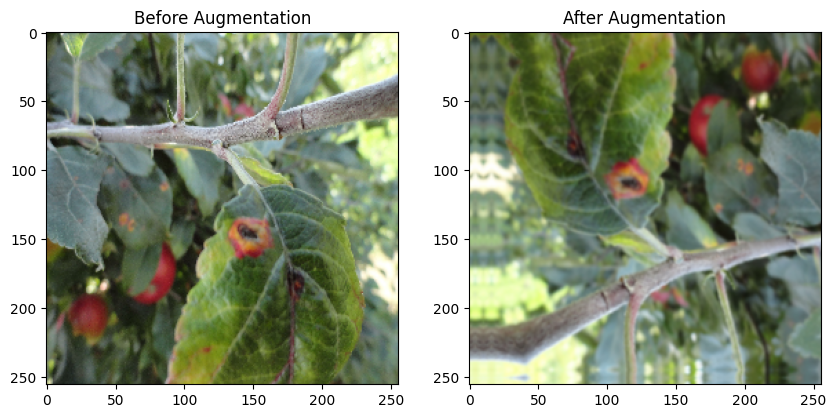

In [20]:
fig, ax = plt.subplots(1, 2, figsize=[10, 5])  # Use plt.subplots instead of plt.subplot

# Image numpy array before and after augmentation
Before_img = first_image.numpy().astype("uint8")
After_img = data_augmentation_layer(image)

ax[0].imshow(Before_img)
ax[0].set_title("Before Augmentation")  

ax[1].imshow(After_img.astype("uint8"))
ax[1].set_title("After Augmentation")  

plt.show()

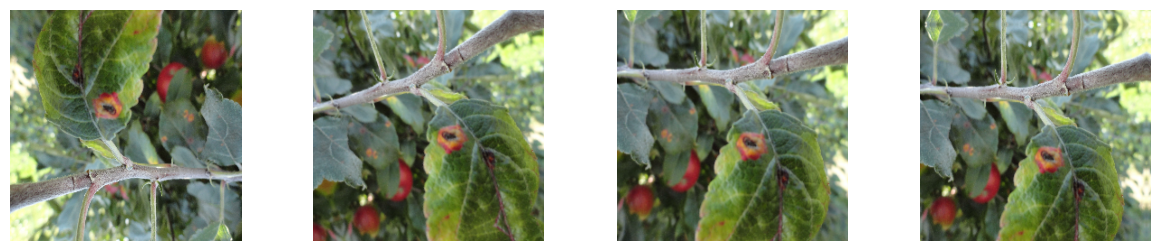

In [21]:
# Now just for testing let's take a single image and apply preprocessing on it
for img,labels in train_ds.take(1):
    single_img = img[0].numpy()
    break

# Apply data augmentation to the single image
fig, ax = plt.subplots(1, 4, figsize=(15, 3))
for i, layer in enumerate(data_augmentation_layer.layers):
    augmented_image = layer(tf.expand_dims(single_img, axis=0), training=True)
    ax[i].imshow(augmented_image[0].numpy().astype("uint8"))
    ax[i].axis("off")

plt.show()

In [22]:
# Defining the layer for resizing and rescaling
Resize_Rescale_layer = Sequential([
  layers.Resizing(256, 256),
  layers.Rescaling(scale = 1./255),
])

# Model building

In [23]:
input_shape = (16, 256, 256, 3)
n_classes = 3

model = Sequential([
    data_augmentation_layer,
    Resize_Rescale_layer,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (256, 256, 3)             0         
                                                                 
 sequential_2 (Sequential)   (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (16, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 62, 62, 64)          0         
 g2D)                                                 

In [24]:
# Compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

- Number of epochs
- Using some pretrained architecture

In [28]:
# Training the model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
history = model.fit(train_ds,
                     epochs=num_epochs, 
                     validation_data=val_ds,
                     callbacks =[early_stop],
                     verbose=1)

Epoch 1/30
83/83 [==============================] - 4s 47ms/step - loss: 0.0891 - accuracy: 0.9667 - val_loss: 0.2749 - val_accuracy: 0.9167
Epoch 2/30
83/83 [==============================] - 4s 46ms/step - loss: 0.1046 - accuracy: 0.9660 - val_loss: 0.0442 - val_accuracy: 0.9833
Epoch 3/30
83/83 [==============================] - 4s 46ms/step - loss: 0.0875 - accuracy: 0.9697 - val_loss: 0.1655 - val_accuracy: 0.9333
Epoch 4/30
83/83 [==============================] - 4s 46ms/step - loss: 0.0952 - accuracy: 0.9682 - val_loss: 0.1687 - val_accuracy: 0.9333
Epoch 5/30
83/83 [==============================] - 4s 46ms/step - loss: 0.0996 - accuracy: 0.9637 - val_loss: 0.2351 - val_accuracy: 0.9333
Epoch 6/30
83/83 [==============================] - 4s 45ms/step - loss: 0.0739 - accuracy: 0.9758 - val_loss: 0.1296 - val_accuracy: 0.9667
Epoch 7/30
83/83 [==============================] - 4s 47ms/step - loss: 0.1015 - accuracy: 0.9697 - val_loss: 0.0876 - val_accuracy: 0.9833


In [31]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_ds)
print("Loss : ",loss)
print("Accuracy : ",accuracy)

4/4 [==============================] - 0s 15ms/step - loss: 0.0442 - accuracy: 0.9833
Loss :  0.044169504195451736
Accuracy :  0.9833333492279053


# Saving the trained Model

In [36]:
# Save the entire model as a `.keras` zip archive.
model.save('/kaggle/working/Model.keras')